<h1>Exploratory data analisys<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Resources-used" data-toc-modified-id="Resources-used-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Resources used</a></span></li><li><span><a href="#Loading-and-Visualization-data" data-toc-modified-id="Loading-and-Visualization-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading and Visualization data</a></span></li><li><span><a href="#Preprocessing-data" data-toc-modified-id="Preprocessing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing data</a></span></li><li><span><a href="#Correlation-matrix-of-initial-features" data-toc-modified-id="Correlation-matrix-of-initial-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlation matrix of initial features</a></span></li><li><span><a href="#Feature-important" data-toc-modified-id="Feature-important-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature important</a></span></li><li><span><a href="#Example-of-a-XGBoost-Decision-Tree" data-toc-modified-id="Example-of-a-XGBoost-Decision-Tree-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Example of a XGBoost Decision Tree</a></span></li></ul></div>

# Resources used

In [1]:
import os
import re
import locale
import requests
import warnings
import calendar
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from platform import python_version
import xgboost as xgb
import graphviz
from datetime import time
from datetime import datetime
from datetime import timedelta
import sklearn
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV

print(f"python: v {python_version()}")
print(f"Jupyter Notebook: v {notebook.__version__}")
print(f"numpy: v {np.__version__}")
print(f"pandas: v {pd.__version__}")
print(f"seaborn: v {sns.__version__}")
print(f"graphviz: v {graphviz.__version__}")
print(f"matplotlib: v {matplotlib.__version__}")
print(f"sklearn: v {sklearn.__version__}")
print(f"XGBoost: v {xgb.__version__}")

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12

python: v 3.10.7
Jupyter Notebook: v 6.4.12
numpy: v 1.25.2
pandas: v 2.2.3
seaborn: v 0.13.2
graphviz: v 0.20.1
matplotlib: v 3.6.2
sklearn: v 1.4.2
XGBoost: v 2.1.2


# Loading and Visualization data

Loading Data

In [2]:
df = pd.read_excel('DataBase.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109032 entries, 0 to 109031
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         109032 non-null  datetime64[ns]
 1   Year         109032 non-null  int64         
 2   Month        109032 non-null  int64         
 3   Day          109032 non-null  int64         
 4   Hour         109032 non-null  int64         
 5   Weekday      109032 non-null  int64         
 6   Volume       109032 non-null  float64       
 7   Temperature  109032 non-null  float64       
 8   PredCons     109032 non-null  int64         
 9   ActCons      109032 non-null  int64         
 10  PredGen      109032 non-null  int64         
 11  ActGen       109032 non-null  int64         
 12  Price        109032 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(10)
memory usage: 10.8 MB


Graph of the structure (averaged by days of the week) of electricity consumption for 12.5 years

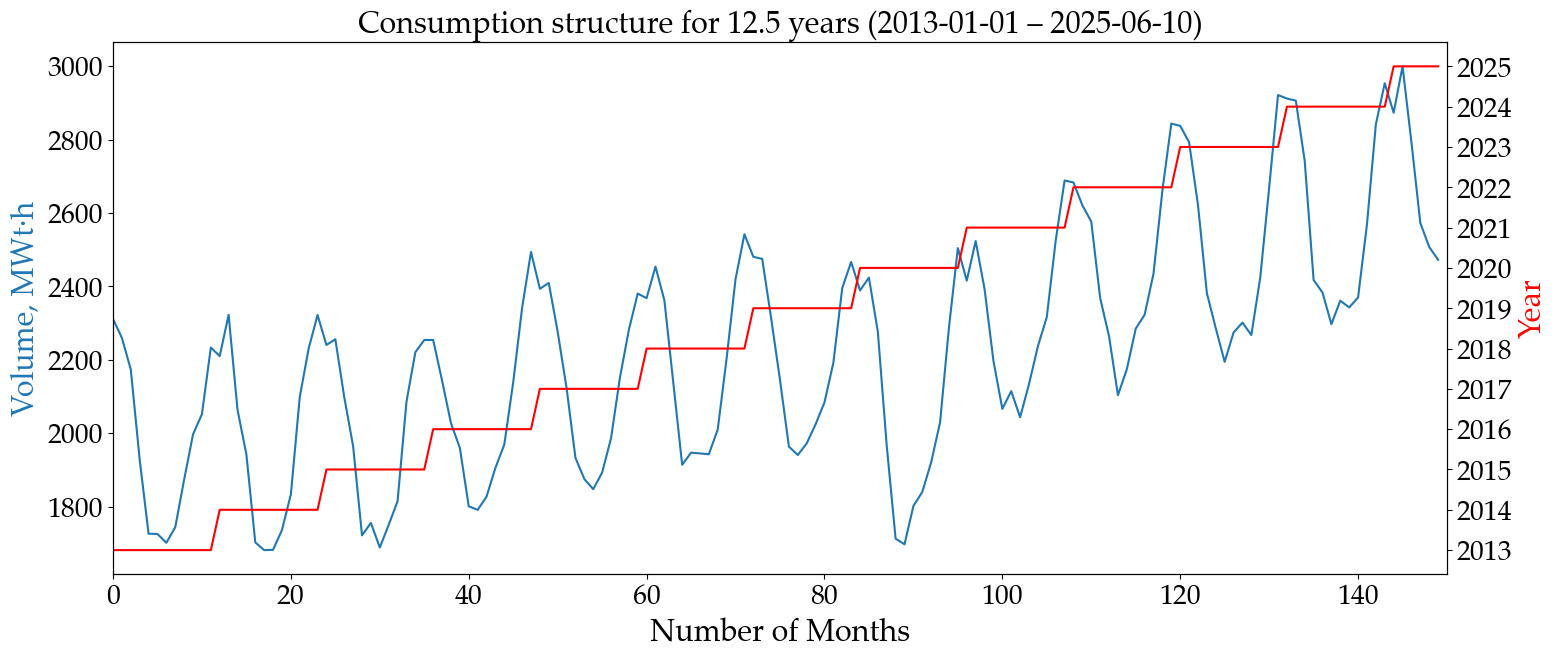

In [4]:
def graf_full_consumption(df, fontsize=20):
    
    #df_group = df.groupby(['Year', 'Month', 'Weekday'])[['Volume']].mean()
    df_group = df.groupby(['Year', 'Month'])[['Volume']].mean()
    df_group.reset_index(inplace=True)
    #df_group = df_general.copy()  # unlock if necessary to cancel the grouping of parameters

    fig, df_volume = plt.subplots(figsize=(16,7))
    df_year = df_volume.twinx()

    df_volume.plot(df_group.Volume, label='Volume')
    df_year.plot(df_group.Year, label='Year', color='red')

    plt.rcParams['font.size'] = fontsize

    df_volume.set_xlim(0, df_group.shape[0])
    #df_volume.set_ylim(df_group['Volume'].min(), df_group['Volume'].max())  # диапазон 'volume' от min до max
    df_volume.set_ylabel('Volume, MWt·h', fontsize=fontsize+2, color='#1f77b4')
    #df_volume.set_xlabel('Number of records averaged by days of the week', fontsize=fontsize+2)
    df_volume.set_xlabel('Number of Months', fontsize=fontsize+2)
    df_year.set_ylabel('Year', fontsize=fontsize+2, color='r')
    df_year.yaxis.set_major_locator(ticker.MultipleLocator(1.00))

    plt.title(f'Сonsumption structure for 12.5 years ({df.iloc[0].Date.date()} – {df.iloc[-1].Date.date()})', 
              fontsize=fontsize+2)
    
    #plt.legend()
    plt.tight_layout()
    plt.savefig('pictures/graf_full_consumption.png', dpi = 300, transparent = True)
    
    plt.show()
    
graf_full_consumption(df)

Graph of the structure (averaged by days) of electricity consumption for 2024

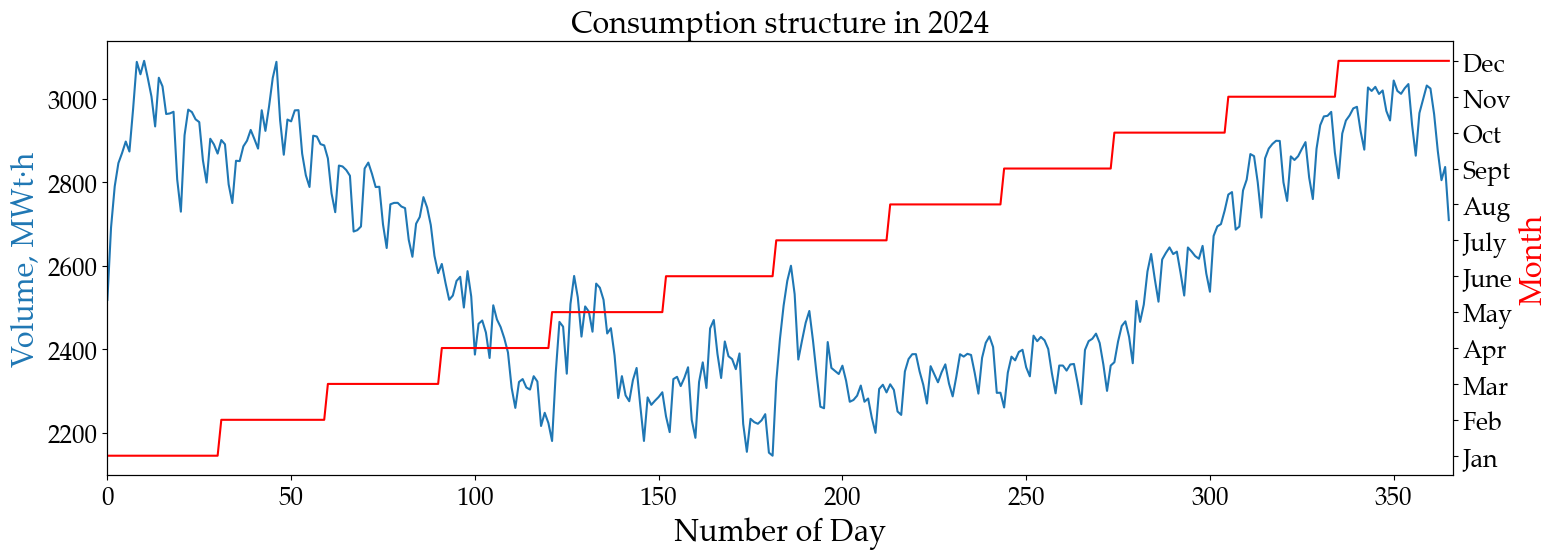

In [33]:
def graf_year_consumption(df, year, fontsize=20):
    
    df_year = df[df.Year == year]
    df_year.reset_index(drop=True, inplace=True)

    df_group_year = df_year.groupby(['Month', 'Day'])[['Volume']].mean()
    df_group_year.reset_index(inplace=True)
    #df_group_year = df_year.copy()  # unlock if necessary to cancel the grouping of parameters

    fig, df_volume = plt.subplots(figsize=(16,6))
    df_month = df_volume.twinx()

    df_volume.plot(df_group_year.Volume, label='Volume')
    df_month.plot(df_group_year.Month, label='Month', color='r')

    plt.rcParams['font.size'] = fontsize

    df_volume.set_xlim(0, df_group_year.shape[0])
    df_volume.set_ylabel('Volume, MWt·h', fontsize=fontsize+2, color='#1f77b4')
    df_volume.set_xlabel('Number of Day', fontsize=fontsize+2)
    df_month.yaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, 13)]))
    df_month.set_ylabel('Month', fontsize=fontsize+2, color='r')
    df_month.yaxis.set_major_formatter(ticker.FixedFormatter(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 
                                                              'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']))

    plt.title(f'Сonsumption structure in {year}', fontsize=fontsize+2)
    
    #plt.legend()
    plt.tight_layout()
    plt.savefig(f'pictures/graf_year_consumption({year}).png', dpi = 300, transparent = True)
    
    plt.show()
    
graf_year_consumption(df, 2024)

Graph of the dependence of daily average temperature on daily average energy consumption for 2024

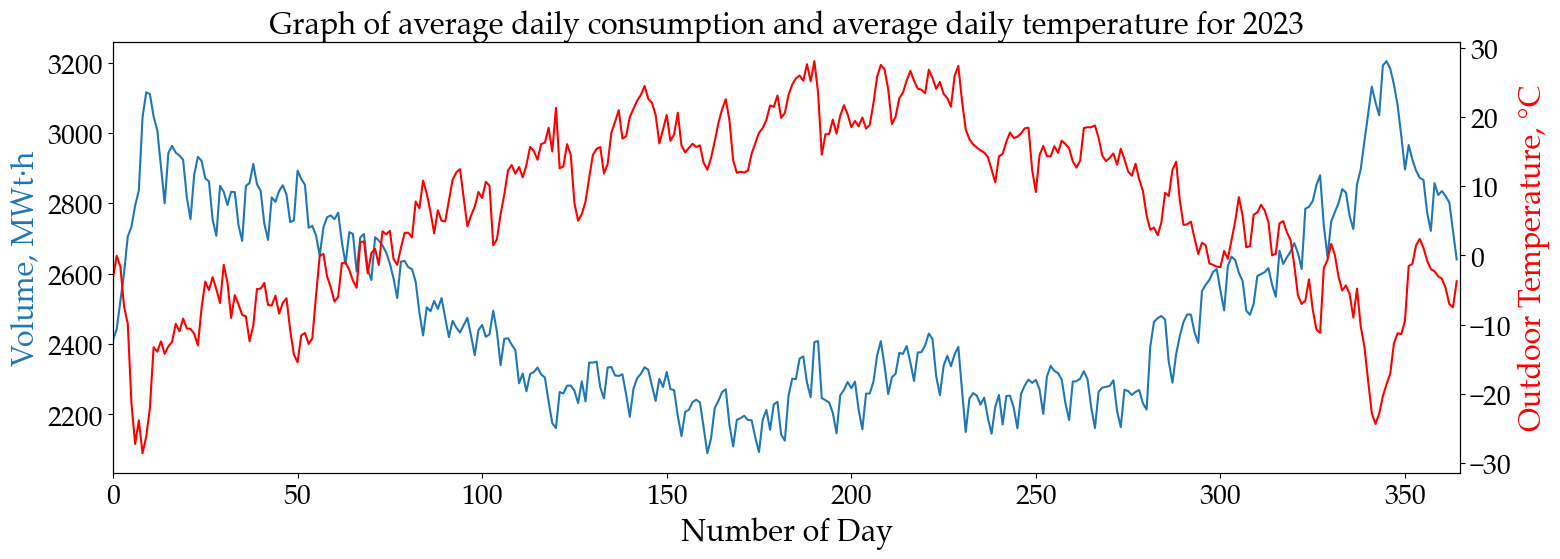

In [5]:
def graf_temp_cons_corr(df, year, fontsize=20):    
    
    df_year = df[df.Year == year]
    df_year.reset_index(drop=True, inplace=True)

    df_group_year = df_year.groupby(['Month', 'Day'])[['Volume', 'Temperature']].mean()
    df_group_year.reset_index(inplace=True) 

    fig, df_volume = plt.subplots(figsize=(16,6))
    df_temperature = df_volume.twinx()

    df_volume.plot(df_group_year.Volume, color='#1f77b4', label='Volume')

    df_temperature.plot(df_group_year.Temperature, color = 'red', label = 'Temperature')

    plt.rcParams['font.size'] = fontsize

    df_volume.set_xlim(0, df_group_year.shape[0])
    df_volume.set_ylabel('Volume, MWt·h', fontsize=fontsize+2, color='#1f77b4')
    df_volume.set_xlabel('Number of Day', fontsize=fontsize+2)
    df_temperature.set_ylabel('Outdoor Temperature, °C', fontsize=fontsize+2, color='red')

    plt.title(f'Graph of average daily consumption and average daily temperature for {year}', fontsize=fontsize+2)
    
    plt.tight_layout()
    plt.savefig(f'pictures/graf_temp_cons_corr({year}).png', dpi = 300, transparent = True)
    
    plt.show()
    
graf_temp_cons_corr(df, 2023)

Graph of the structure of electricity consumption by days of the week during the month

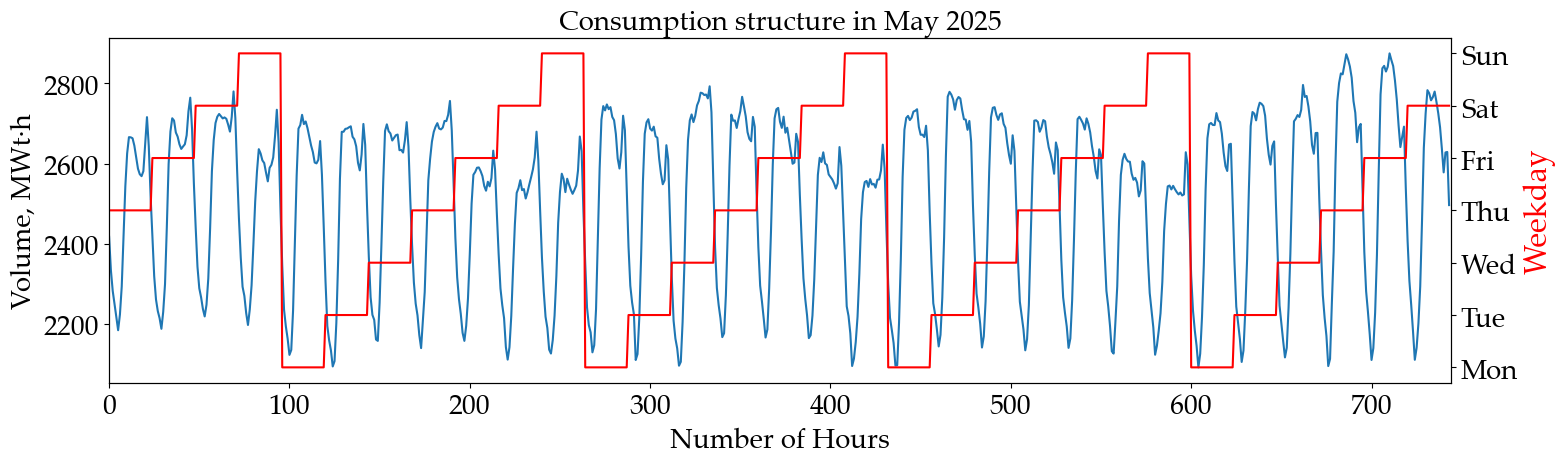

In [32]:
def graf_month_consumption(df, year, month, fontsize=20):    
    
    months = list(name for name in calendar.month_name)

    df_month = df[(df.Year == year) & (df.Month == month)]  # We limit the data frame to the month of interest to us
    df_month.reset_index(drop=True, inplace=True)

    fig, df_volume = plt.subplots(figsize=(16,5))
    df_weekday = df_volume.twinx()

    df_volume.plot(df_month['Volume'], label='Volume')
    df_weekday.plot(df_month['Weekday'], label='Weekday', color='r')

    plt.rcParams['font.size'] = fontsize-2

    df_volume.set_xlim(0, df_month.shape[0])
    df_volume.set_ylabel('Volume, MWt·h', fontsize=fontsize)
    df_volume.set_xlabel('Number of Hours', fontsize=fontsize)
    df_weekday.set_ylabel('Weekday', fontsize=fontsize+2, color='r')
    df_weekday.yaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3, 4, 5, 6]))
    df_weekday.yaxis.set_major_formatter(ticker.FixedFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

    plt.title(f'Сonsumption structure in {months[month]} {year}', fontsize=fontsize)
    #plt.legend(loc = 'lower right')
    
    plt.tight_layout()
    plt.savefig(f'pictures/graf_month_consumption({months[month]} {year}).png', dpi = 300, transparent = True)
    
    plt.show()
    
graf_month_consumption(df, 2025, 5)

# Preprocessing data

In [4]:
def get_type_day(df):  # coding of weekends and holidays
    
    holidays = [
                datetime(2013, 1, 1).date(), datetime(2013, 1, 2).date(), datetime(2013, 1, 3).date(), datetime(2013, 1, 4).date(), datetime(2013, 1, 5).date(), datetime(2013, 1, 6).date(), datetime(2013, 1, 7).date(), datetime(2013, 1, 8).date(), datetime(2013, 2, 23).date(), datetime(2013, 3, 8).date(), datetime(2013, 5, 1).date(), datetime(2013, 5, 9).date(), datetime(2013, 6, 12).date(), datetime(2013, 8, 8).date(), datetime(2013, 8, 30).date(), datetime(2013, 10, 15).date(), datetime(2013, 11, 4).date(), datetime(2013, 11, 6).date(),
                datetime(2014, 1, 1).date(), datetime(2014, 1, 2).date(), datetime(2014, 1, 3).date(), datetime(2014, 1, 4).date(), datetime(2014, 1, 5).date(), datetime(2014, 1, 6).date(), datetime(2014, 1, 7).date(), datetime(2014, 1, 8).date(), datetime(2014, 2, 23).date(), datetime(2014, 3, 8).date(), datetime(2014, 5, 1).date(), datetime(2014, 5, 9).date(), datetime(2014, 6, 12).date(), datetime(2014, 7, 28).date(), datetime(2014, 8, 30).date(), datetime(2014, 10, 4).date(), datetime(2014, 11, 4).date(), datetime(2014, 11, 6).date(),
                datetime(2015, 1, 1).date(), datetime(2015, 1, 2).date(), datetime(2015, 1, 3).date(), datetime(2015, 1, 4).date(), datetime(2015, 1, 5).date(), datetime(2015, 1, 6).date(), datetime(2015, 1, 7).date(), datetime(2015, 1, 8).date(), datetime(2015, 2, 23).date(), datetime(2015, 3, 8).date(), datetime(2015, 5, 1).date(), datetime(2015, 5, 9).date(), datetime(2015, 6, 12).date(), datetime(2015, 7, 17).date(), datetime(2015, 8, 30).date(), datetime(2015, 9, 24).date(), datetime(2015, 11, 4).date(), datetime(2015, 11, 6).date(),
                datetime(2016, 1, 1).date(), datetime(2016, 1, 2).date(), datetime(2016, 1, 3).date(), datetime(2016, 1, 4).date(), datetime(2016, 1, 5).date(), datetime(2016, 1, 6).date(), datetime(2016, 1, 7).date(), datetime(2016, 1, 8).date(), datetime(2016, 2, 23).date(), datetime(2016, 3, 8).date(), datetime(2016, 5, 1).date(), datetime(2016, 5, 9).date(), datetime(2016, 6, 12).date(), datetime(2016, 7, 5).date(), datetime(2016, 8, 30).date(), datetime(2016, 9, 12).date(), datetime(2016, 11, 4).date(), datetime(2016, 11, 6).date(),
                datetime(2017, 1, 1).date(), datetime(2017, 1, 2).date(), datetime(2017, 1, 3).date(), datetime(2017, 1, 4).date(), datetime(2017, 1, 5).date(), datetime(2017, 1, 6).date(), datetime(2017, 1, 7).date(), datetime(2017, 1, 8).date(), datetime(2017, 2, 23).date(), datetime(2017, 3, 8).date(), datetime(2017, 5, 1).date(), datetime(2017, 5, 9).date(), datetime(2017, 6, 12).date(), datetime(2017, 6, 25).date(), datetime(2017, 8, 30).date(), datetime(2017, 9, 1).date(), datetime(2017, 11, 4).date(), datetime(2017, 11, 6).date(),
                datetime(2018, 1, 1).date(), datetime(2018, 1, 2).date(), datetime(2018, 1, 3).date(), datetime(2018, 1, 4).date(), datetime(2018, 1, 5).date(), datetime(2018, 1, 6).date(), datetime(2018, 1, 7).date(), datetime(2018, 1, 8).date(), datetime(2018, 2, 23).date(), datetime(2018, 3, 8).date(), datetime(2018, 5, 1).date(), datetime(2018, 5, 9).date(), datetime(2018, 6, 12).date(), datetime(2018, 6, 15).date(), datetime(2018, 8, 21).date(), datetime(2018, 8, 30).date(), datetime(2018, 11, 4).date(), datetime(2018, 11, 6).date(),
                datetime(2019, 1, 1).date(), datetime(2019, 1, 2).date(), datetime(2019, 1, 3).date(), datetime(2019, 1, 4).date(), datetime(2019, 1, 5).date(), datetime(2019, 1, 6).date(), datetime(2019, 1, 7).date(), datetime(2019, 1, 8).date(), datetime(2019, 2, 23).date(), datetime(2019, 3, 8).date(), datetime(2019, 5, 1).date(), datetime(2019, 5, 9).date(), datetime(2019, 6, 4).date(), datetime(2019, 6, 12).date(), datetime(2019, 8, 11).date(), datetime(2019, 8, 30).date(), datetime(2019, 11, 4).date(), datetime(2019, 11, 6).date(),
                datetime(2020, 1, 1).date(), datetime(2020, 1, 2).date(), datetime(2020, 1, 3).date(), datetime(2020, 1, 4).date(), datetime(2020, 1, 5).date(), datetime(2020, 1, 6).date(), datetime(2020, 1, 7).date(), datetime(2020, 1, 8).date(), datetime(2020, 2, 23).date(), datetime(2020, 3, 8).date(), datetime(2020, 5, 1).date(), datetime(2020, 5, 9).date(), datetime(2020, 5, 24).date(), datetime(2020, 6, 12).date(), datetime(2020, 7, 31).date(), datetime(2020, 8, 30).date(), datetime(2020, 11, 4).date(), datetime(2020, 11, 6).date(),
                datetime(2021, 1, 1).date(), datetime(2021, 1, 2).date(), datetime(2021, 1, 3).date(), datetime(2021, 1, 4).date(), datetime(2021, 1, 5).date(), datetime(2021, 1, 6).date(), datetime(2021, 1, 7).date(), datetime(2021, 1, 8).date(), datetime(2021, 2, 23).date(), datetime(2021, 3, 8).date(), datetime(2021, 5, 1).date(), datetime(2021, 5, 9).date(), datetime(2021, 5, 13).date(), datetime(2021, 6, 12).date(), datetime(2021, 7, 20).date(), datetime(2021, 8, 30).date(), datetime(2021, 11, 4).date(), datetime(2021, 11, 4).date(),
                datetime(2022, 1, 1).date(), datetime(2022, 1, 2).date(), datetime(2022, 1, 3).date(), datetime(2022, 1, 4).date(), datetime(2022, 1, 5).date(), datetime(2022, 1, 6).date(), datetime(2022, 1, 7).date(), datetime(2022, 1, 8).date(), datetime(2022, 2, 23).date(), datetime(2022, 3, 8).date(), datetime(2022, 5, 1).date(), datetime(2022, 5, 2).date(), datetime(2022, 5, 9).date(), datetime(2022, 6, 12).date(), datetime(2022, 7, 9).date(), datetime(2022, 8, 30).date(), datetime(2022, 11, 4).date(), datetime(2022, 11, 6).date(),
                datetime(2023, 1, 1).date(), datetime(2023, 1, 2).date(), datetime(2023, 1, 3).date(), datetime(2023, 1, 4).date(), datetime(2023, 1, 5).date(), datetime(2023, 1, 6).date(), datetime(2023, 1, 7).date(), datetime(2023, 1, 8).date(), datetime(2023, 2, 23).date(), datetime(2023, 3, 8).date(), datetime(2023, 4, 21).date(), datetime(2023, 5, 1).date(), datetime(2023, 5, 9).date(), datetime(2023, 6, 12).date(), datetime(2023, 6, 28).date(), datetime(2023, 8, 30).date(), datetime(2023, 11, 4).date(), datetime(2023, 11, 6).date(),
                datetime(2024, 1, 1).date(), datetime(2024, 1, 2).date(), datetime(2024, 1, 3).date(), datetime(2024, 1, 4).date(), datetime(2024, 1, 5).date(), datetime(2024, 1, 6).date(), datetime(2024, 1, 7).date(), datetime(2024, 1, 8).date(), datetime(2024, 2, 23).date(), datetime(2024, 3, 8).date(), datetime(2024, 4, 10).date(), datetime(2024, 5, 1).date(), datetime(2024, 5, 9).date(), datetime(2024, 6, 12).date(), datetime(2024, 6, 16).date(), datetime(2024, 8, 30).date(), datetime(2024, 11, 4).date(), datetime(2024, 11, 6).date(),
                datetime(2025, 1, 1).date(), datetime(2025, 1, 2).date(), datetime(2025, 1, 3).date(), datetime(2025, 1, 4).date(), datetime(2025, 1, 5).date(), datetime(2025, 1, 6).date(), datetime(2025, 1, 7).date(), datetime(2025, 1, 8).date(), datetime(2025, 2, 23).date(), datetime(2025, 3, 8).date(), datetime(2025, 3, 30).date(), datetime(2025, 5, 1).date(), datetime(2025, 5, 9).date(), datetime(2025, 6, 6).date(), datetime(2025, 6, 12).date(), datetime(2025, 8, 30).date(), datetime(2025, 11, 4).date(), datetime(2025, 11, 6).date(),              
               ]
    
    weekend = [
               datetime(2013, 5, 2).date(), datetime(2013, 5, 3).date(), datetime(2013, 5, 10).date(),
               datetime(2014, 3, 10).date(), datetime(2014, 5, 2).date(), datetime(2014, 6, 13).date(), datetime(2014, 9, 1).date(), datetime(2014, 10, 6).date(), datetime(2014, 11, 3).date(), 
               datetime(2015, 1, 9).date(), datetime(2015, 3, 9).date(), datetime(2015, 5, 4).date(), datetime(2015, 5, 11).date(), datetime(2015, 8, 31).date(),
               datetime(2016, 2, 22).date(), datetime(2016, 3, 7).date(), datetime(2016, 5, 2).date(), datetime(2016, 5, 3).date(), datetime(2016, 6, 13).date(), datetime(2016, 11, 7).date(),
               datetime(2017, 2, 24).date(), datetime(2017, 5, 8).date(),
               datetime(2018, 3, 9).date(), datetime(2018, 4, 30).date(), datetime(2018, 5, 2).date(), datetime(2018, 6, 11).date(), datetime(2018, 11, 5).date(), datetime(2018, 12, 31).date(),
               datetime(2019, 5, 2).date(), datetime(2019, 5, 3).date(), datetime(2019, 5, 10).date(),
               datetime(2020, 2, 24).date(), datetime(2020, 3, 9).date(), datetime(2020, 5, 4).date(), datetime(2020, 5, 5).date(), datetime(2020, 5, 11).date(),
               datetime(2021, 2, 22).date(), datetime(2021, 5, 3).date(), datetime(2021, 5, 10).date(), datetime(2021, 6, 14).date(), datetime(2021, 11, 5).date(), datetime(2021, 12, 31).date(),
               datetime(2022, 3, 7).date(), datetime(2022, 5, 3).date(), datetime(2022, 5, 10).date(), datetime(2022, 6, 13).date(),
               datetime(2023, 2, 24).date(), datetime(2023, 5, 8).date(),
               datetime(2024, 4, 29).date(), datetime(2024, 4, 30).date(), datetime(2024, 5, 10).date(), datetime(2024, 12, 30).date(), datetime(2024, 12, 31).date(),
               datetime(2025, 5, 2).date(), datetime(2025, 5, 8).date(), datetime(2025, 6, 13).date(), datetime(2025, 11, 3).date(), datetime(2025, 12, 31).date() 
              ]
    
    pre_holidays = [
                    datetime(2013, 2, 22).date(), datetime(2013, 3, 7).date(), datetime(2013, 4, 30).date(), datetime(2013, 5, 8).date(), datetime(2013, 6, 11).date(), datetime(2013, 8, 7).date(), datetime(2013, 8, 29).date(), datetime(2013, 10, 14).date(), datetime(2013, 11, 5).date(), datetime(2013, 12, 31).date(),
                    datetime(2014, 2, 24).date(), datetime(2014, 3, 7).date(), datetime(2014, 4, 30).date(), datetime(2014, 5, 8).date(), datetime(2014, 6, 11).date(), datetime(2014, 8, 29).date(), datetime(2014, 10, 3).date(), datetime(2014, 11, 5).date(), datetime(2014, 12, 31).date(),
                    datetime(2015, 4, 30).date(), datetime(2015, 5, 8).date(), datetime(2015, 6, 11).date(), datetime(2015, 7, 16).date(), datetime(2015, 9, 23).date(), datetime(2015, 11, 3).date(), datetime(2015, 11, 5).date(), datetime(2015, 12, 31).date(),
                    datetime(2016, 2, 20).date(), datetime(2016, 7, 4).date(), datetime(2016, 8, 29).date(), datetime(2016, 11, 3).date(),
                    datetime(2017, 2, 22).date(), datetime(2017, 3, 7).date(), datetime(2017, 8, 29).date(), datetime(2017, 8, 31).date(), datetime(2017, 11, 3).date(),            
                    datetime(2018, 2, 22).date(), datetime(2018, 3, 7).date(), datetime(2018, 4, 28).date(), datetime(2018, 5, 8).date(), datetime(2018, 6, 9).date(), datetime(2018, 6, 14).date(), datetime(2018, 7, 20).date(), datetime(2018, 7, 29).date(), datetime(2018, 12, 29).date(),
                    datetime(2019, 2, 22).date(), datetime(2019, 3, 7).date(), datetime(2019, 4, 30).date(), datetime(2019, 5, 8).date(), datetime(2019, 6, 3).date(), datetime(2019, 6, 11).date(), datetime(2019, 8, 29).date(), datetime(2019, 11, 5).date(), datetime(2019, 12, 31).date(),
                    datetime(2020, 4, 30).date(), datetime(2020, 5, 8).date(), datetime(2020, 6, 11).date(), datetime(2020, 7, 30).date(), datetime(2020, 11, 3).date(), datetime(2020, 11, 5).date(), datetime(2020, 12, 31).date(),
                    datetime(2021, 2, 20).date(), datetime(2021, 4, 30).date(), datetime(2021, 5, 12).date(), datetime(2021, 6, 11).date(), datetime(2021, 7, 19).date(), datetime(2021, 11, 3).date(),
                    datetime(2022, 2, 22).date(), datetime(2022, 3, 5).date(), datetime(2022, 7, 8).date(), datetime(2022, 8, 29).date(), datetime(2022, 11, 3).date(),
                    datetime(2023, 2, 22).date(), datetime(2023, 3, 7).date(), datetime(2023, 4, 20).date(),  datetime(2023, 6, 27).date(), datetime(2023, 8, 29).date(), datetime(2023, 11, 3).date(),
                    datetime(2024, 2, 22).date(), datetime(2024, 3, 7).date(), datetime(2024, 4, 9).date(), datetime(2024, 5, 8).date(), datetime(2024, 6, 11).date(), datetime(2024, 8, 29).date(), datetime(2024, 11, 2).date(), datetime(2024, 11, 5).date(),
                    datetime(2025, 3, 7).date(), datetime(2025, 4, 30).date(), datetime(2025, 6, 5).date(), datetime(2025, 6, 11).date(), datetime(2025, 8, 29).date(), datetime(2025, 11, 1).date(), datetime(2025, 11, 5).date()
                   ]
    
    workdays = [datetime(2024, 4, 27).date(), datetime(2024, 12, 28).date()]
    
    if df.Date.date() in workdays:
        TypeDay = 0
    elif df.Date.date() in pre_holidays:
        TypeDay = 1   
    elif df.Date.date() in weekend:
        TypeDay = 3 
    elif df.Date.date() in holidays:
        TypeDay = 2 
    elif (df.Weekday == 5) | (df.Weekday == 6):
        TypeDay = 3
    else:
        TypeDay = 0
    return TypeDay

In [5]:
def prepareData(df, lag_start=1, lag_end=7):        
        
    # coding of weekends and holidays
    df['TypeDay'] = df.apply(get_type_day, axis=1)
    
    df = df.set_index('Date')
    
    # add daily lags of the original series (default is 1 full week)
    for i in range(lag_start, lag_end + 1):    
        df[f"lag-{i}"] = df.Volume.shift(freq=f"{i}D")  # we make a shift to the i-th day by index 

    # delete the first 24*lag_end records with missing data (168 records for a lag of 7 days)
    df = df.dropna(subset=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'lag-5', 'lag-6', 'lag-7'])
    df.reset_index(inplace=True)
    
    return df

Adding/removing/changing features

In [6]:
# we form a general population
df_general = df.copy()

# adding new features
df_general = prepareData(df_general)

# we delete columns with forecast values of electricity consumption and generation in the Balancing Market
df_general = df_general.drop(columns=['PredCons', 'PredGen'])

df_general.iloc[:, 1:]

,Year,Month,Day,Hour,Weekday,Volume,Temperature,ActCons,ActGen,Price,TypeDay,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2013,1,8,1,1,2017.102000,-6.1,2875,2568,0,2,1983.630000,1984.007000,2000.216000,1972.473000,2008.811000,2027.193000,2033.264000
1,2013,1,8,2,1,1964.942000,-6.1,2781,2580,0,2,1932.213000,1934.204000,1950.523000,1920.304000,1953.228000,1970.887000,1987.714000
2,2013,1,8,3,1,1938.221000,-6.0,2737,2581,0,2,1904.510000,1907.831000,1920.106000,1889.606000,1915.720000,1938.669000,1955.861000
3,2013,1,8,4,1,1929.957000,-6.0,2761,2576,0,2,1895.918000,1897.508000,1915.331000,1882.192000,1904.349000,1931.414000,1944.520000
4,2013,1,8,5,1,1950.473000,-6.0,2763,2575,0,2,1921.034000,1904.977000,1922.729000,1902.160000,1905.641000,1939.466000,1964.332000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108859,2025,6,9,20,0,2721.774653,25.8,4290,3728,2396,0,2598.823747,2495.932241,2509.170162,2561.903797,2539.725131,2563.724502,2613.908383
108860,2025,6,9,21,0,2730.908830,24.0,4295,3607,2100,0,2635.572995,2531.893929,2575.182469,2598.473502,2584.616371,2607.633057,2622.134405
108861,2025,6,9,22,0,2760.499815,22.5,4215,3022,1964,0,2644.562278,2536.011304,2580.107662,2611.434013,2583.034630,2633.566958,2591.983765
108862,2025,6,9,23,0,2602.230175,21.7,3994,2961,1960,0,2488.318808,2416.546642,2469.557023,2468.343446,2418.571382,2465.536150,2442.039994


# Correlation matrix of initial features

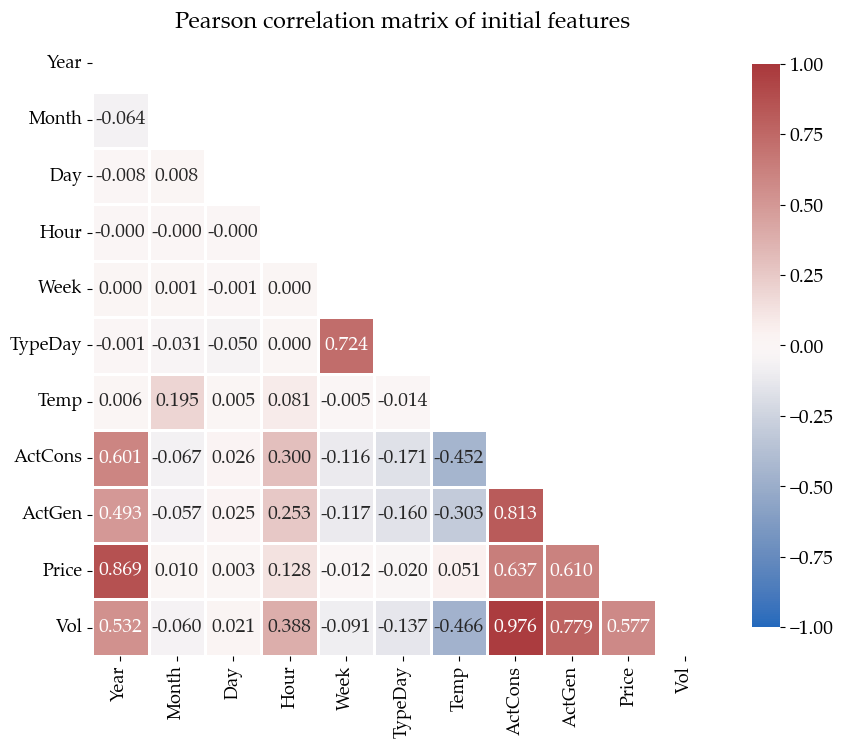

In [20]:
# correlation of initial values and target feature
color_map = sns.color_palette("vlag", as_cmap=True)

df_gen = df_general.iloc[:, 1:-7]
df_gen = df_gen.rename(columns={'Weekday': 'Week', 'Temperature': 'Temp', 'Volume': 'Vol'})
df_gen = df_gen.reindex(columns=['Year', 'Month', 'Day', 'Hour', 'Week', 'TypeDay', 
                                 'Temp', 'ActCons', 'ActGen', 'Price', 'Vol'])

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_gen.corr(), dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(9, 8))

plt.rcParams.update({'font.size': 14, 'font.serif': 'Palatino Linotype'})

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_gen.corr(), annot=True, mask=mask, cmap=color_map, fmt=".3f", vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8}).set(title='Pearson correlation matrix of initial features')

plt.tight_layout()
plt.savefig('pictures/full_corr_matrix.png', dpi = 300, transparent = True)

#df_gen.corr('pearson').style.background_gradient(cmap=color_map, vmin = -1, vmax=1)  # output table-factor

# Feature important

In [86]:
# feature value classification in the context of XGBoost regressor

selector = xgb.XGBRegressor(device='cpu',
                            max_depth=5,
                            n_estimators=200)

result = selector.fit(df_general.drop(columns=['Date', 'Volume']), df_general.Volume)

features_table = pd.DataFrame(result.feature_importances_, 
                              index = df_general.drop(columns=['Date', 'Volume']).columns, 
                              columns = ['importance'])


feature_importances = features_table.sort_values(by='importance', ascending=False)
features_table = feature_importances.T
features_table

,ActCons,lag-1,lag-7,TypeDay,lag-6,Hour,Weekday,Year,Month,Temperature,lag-4,Day,lag-3,Price,ActGen,lag-2,lag-5
importance,0.568735,0.270763,0.123943,0.00645,0.005851,0.005635,0.004028,0.00319,0.002454,0.002361,0.002151,0.001076,0.000944,0.000882,0.000614,0.000532,0.000391


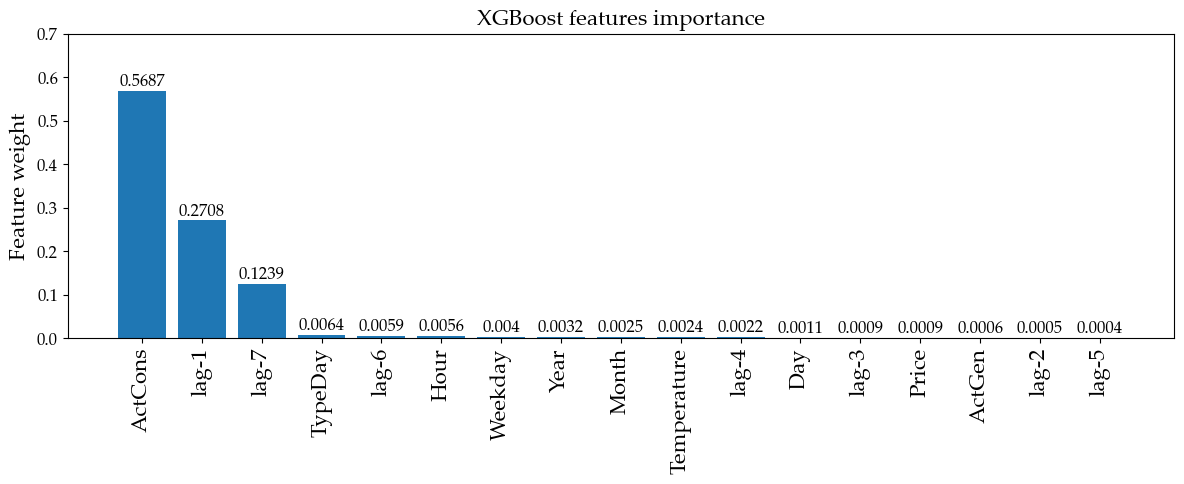

In [85]:
plt.figure(figsize=(12, 5))

for bar in plt.bar(range(len(feature_importances.index)), feature_importances.importance, align='center', width=0.8):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.xticks(range(len(feature_importances.index)), feature_importances.index, rotation=90, fontsize=16)
plt.ylim(0, 0.7)
plt.ylabel('Feature weight', fontsize=16)
plt.title('XGBoost features importance', fontsize=16)
plt.tight_layout()

plt.savefig('pictures/feature_important.png', dpi = 300, transparent = True)
plt.show()

# Example of a XGBoost Decision Tree

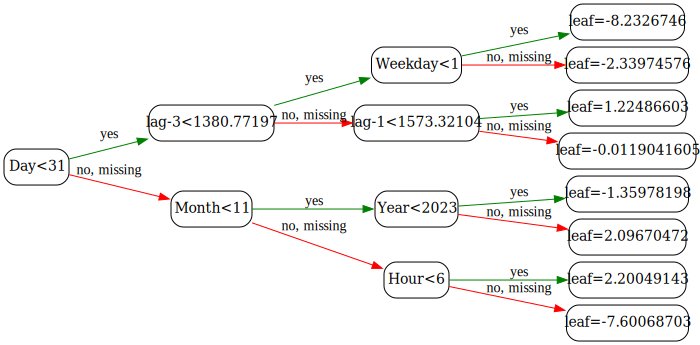

In [125]:
# Drawing the decision tree from the max_depth=3 XGboost model
model = xgb.XGBRegressor(device='cpu',
                         max_depth=3,
                         n_estimators=200)

model.fit(df_general.drop(columns=['Date', 'Volume']), df_general.Volume)

graph_attr = {
    'fontsize': '16pt',
    'ranksep': '0.01',
    'splines': 'line',
    'fontname': 'Palatino Linotype',
    'nodesep' : '0.1'
}

graph = xgb.to_graphviz(model, num_trees=109, 
                        rankdir='LR',
                        **graph_attr,
                        no_color='#008000',
                        yes_color='red',
                        condition_node_params={'shape': 'box', 
                                               'style': 'rounded', 
                                               'fillcolor': 'none', 
                                               'fontname': 'Palatino Linotype',
                                               'fontsize': '14pt'
                                              },
                        leaf_node_params={'shape': 'box', 
                                          'style': 'rounded', 
                                          'fillcolor': 'none',
                                          'penwidth': '1pt',
                                          'fontname': 'Palatino Linotype',
                                          'fontsize': '14pt'},
                       )

graph.render('pictures/xgboost_tree', format='png', view=True, )
graph